# Volume Estimation

This notebook estimates volume for all model radii stored in a given folder as npz files.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import json

# Importing our existing funcs
import os
import sys
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent
sys.path.append(str(parent_dir))
# Import modules

from volume_funcs import (  load_data_files,
                            create_small_data,
                            extract_and_store_train_losses,
                            extract_data,
                            loss_threshold,
                            process_wiggle_results,
                            accuracy_threshold,
                            process_wiggle_accuracy_results,
                            compute_log_power_mean,
                            compute_power_mean,
                            compute_max_radius,
                            plot_pair_metrics,
                            plot_metric_distributions,
                            check_training_explanation,
                            count_disordered_volumes,
                            get_ranks )

In [2]:
"""
Reminder of our saved structure:
        wiggle_results: List of dictionaries containing wiggle test results
        Each dictionary is of the form
        {
        'losses':
        'coefficients':
        'accuracies':
        'perturbation_seed':
        'perturbation_norm':
        }
        model: PyTorch model used in analysis (state_dict will be saved)
        'additional_data': #actual data used to compute the loss landscape
        'model_trained_data': #amount the model was trained on
        'dataset_type':
        'base_dataset_size': 
        'test_loss':
        'test_accuracy':
        And any additional kwargs
"""

"\nReminder of our saved structure:\n        wiggle_results: List of dictionaries containing wiggle test results\n        Each dictionary is of the form\n        {\n        'losses':\n        'coefficients':\n        'accuracies':\n        'perturbation_seed':\n        'perturbation_norm':\n        }\n        model: PyTorch model used in analysis (state_dict will be saved)\n        'additional_data': #actual data used to compute the loss landscape\n        'model_trained_data': #amount the model was trained on\n        'dataset_type':\n        'base_dataset_size': \n        'test_loss':\n        'test_accuracy':\n        And any additional kwargs\n"

## Input Parameters

The input parameters are the folder to analyze, the files in the folder, and the loss and accuracy thresholds to use. Note that to check our thresholds are reasonable, we also print the base loss + accuracy thresholds.

In [3]:
# --- user inputs ---
user_specified_prefix = ""   # or "" if you want current directory
data_type = "data"
data_additive = "0"

# --- build directory ---
directory = os.path.join(user_specified_prefix, f"{data_type}_{data_additive}")

# --- collect all .npz files ---
files_to_load = [f for f in os.listdir(directory) if f.endswith(".npz")]

print("Looking in:", directory)
print("Files to load:", files_to_load)

loss_threshold = 0.1
accuracy_threshold = 0.1

Looking in: data_0
Files to load: ['data_0.npz', 'data_540.npz', 'data_5940.npz', 'data_59940.npz']


In [4]:
data_dictionary = load_data_files(files_to_load, directory=directory)

# Acquire number of parameters
model_key = list(data_dictionary.keys())[0]
num_params = data_dictionary[model_key]['num_params']

loss_landscape_data_param = data_dictionary[model_key]['additional_data']

# Acquire type
dataset_type = data_dictionary[model_key]['dataset_type']
additional_param_level = f"{dataset_type} Level"

# Base train losses for comparison with our threshold
loss_values = extract_and_store_train_losses(data_dictionary)
for model, loss in loss_values.items():
    print(f"{model}: {loss}")

data_0: 2.2631378669757396e-05
data_540: 0.0001231202477356419
data_5940: 0.0003108069358859211
data_59940: 0.0032945391722023487


## Loss Plots

The poisoning values are  [0, 540, 5940, 59940]
The log volumes are  [907798.2220786033, 876842.3634486536, 767852.8970039642, 702123.973600466]
The maximum radii are  [47.493146395247855, 41.63495772600831, 26.19171503147001, 19.8046994566881]
Plot saved to: data_0/average_radius.png


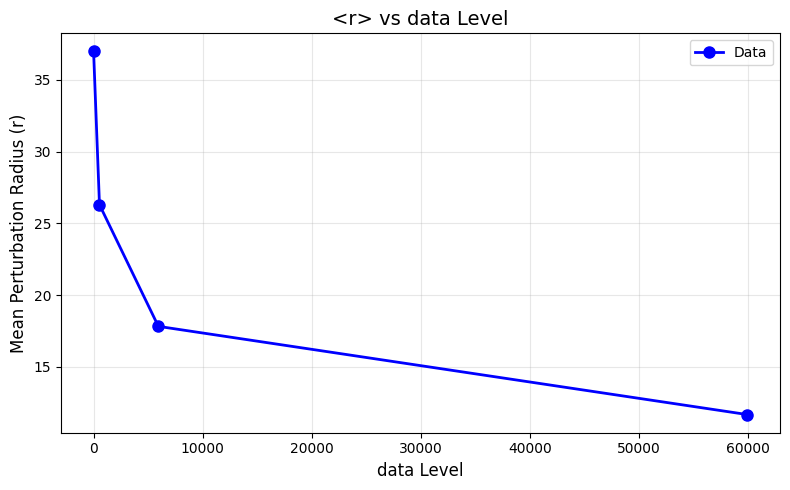

Plot saved to: data_0/log_volume.png


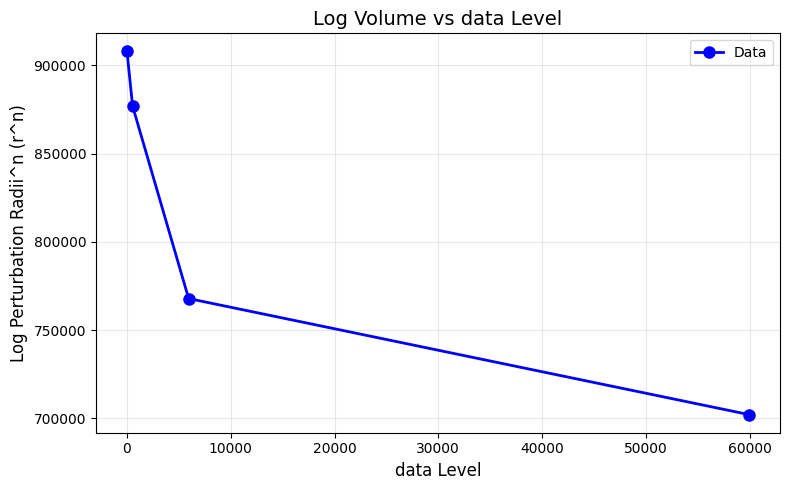

Plot saved to: data_0/radius_histogram.png


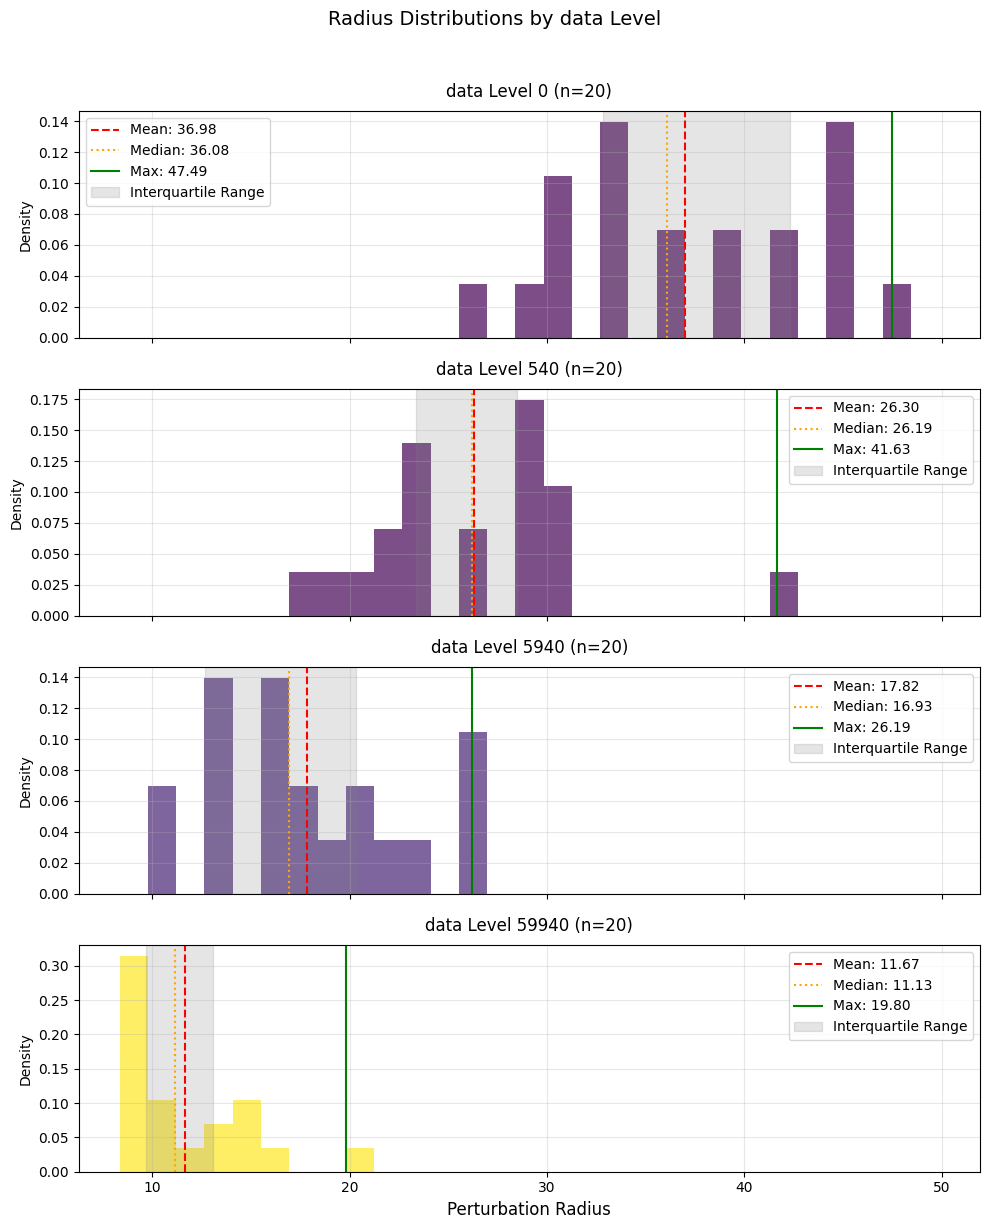

Plot saved to: data_0/log_volume_generalization.png


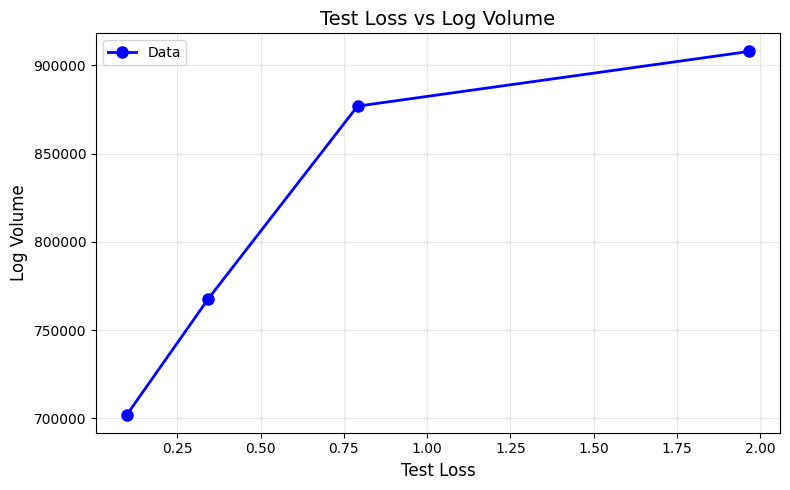

Plot saved to: data_0/model_modification_vs_test_loss.png


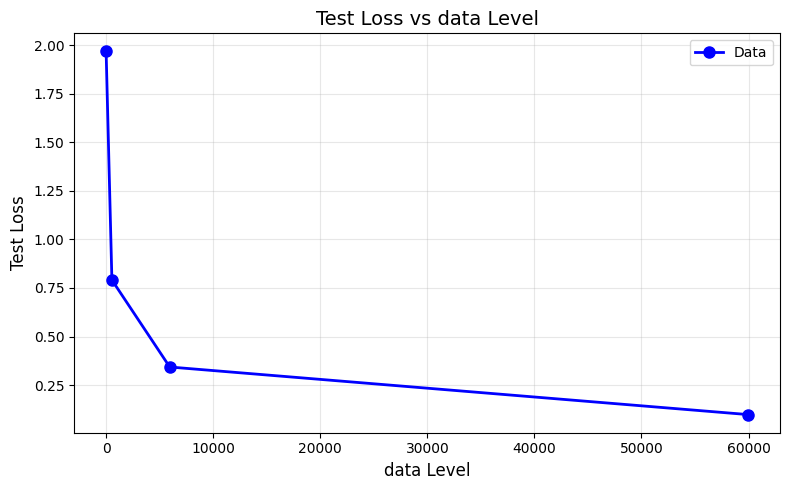

In [5]:
processed_full_data = process_wiggle_results(data_dictionary, threshold=loss_threshold)
model_data_levels, radii_list = extract_data(
    data_dict=processed_full_data,
    x_axis_key='model_trained_data',
    y_axis_key='r_vals'
)

train_loss, test_loss = extract_data(
    data_dict=data_dictionary,
    x_axis_key='train_loss',
    y_axis_key='test_loss'
)

power_mean_1 = compute_power_mean(radii_list, exponent=1.0)  # Regular mean
log_exp_r_n = compute_log_power_mean(radii_list, exponent=num_params) 
max_radii = compute_max_radius(radii_list)
print ("The poisoning values are ", model_data_levels)
print ("The log volumes are ", log_exp_r_n)
print ("The maximum radii are ", max_radii)

# Average radii
plot_pair_metrics( 
    metric1_values=model_data_levels,
    metric2_values=power_mean_1,
    xlabel=additional_param_level,
    ylabel="Mean Perturbation Radius (r)",
    title="<r> vs "+additional_param_level,
    save_path = directory + "/average_radius.png"
)

# Log volume (r^n)
plot_pair_metrics(
    metric1_values=model_data_levels,
    metric2_values=log_exp_r_n,
    xlabel=additional_param_level,
    ylabel="Log Perturbation Radii^n (r^n)",
    title="Log Volume vs "+additional_param_level,
    #log_scale=True,  # Products often span many orders of magnitude
    save_path = directory + "/log_volume.png"
)

# Radius histogram
plot_metric_distributions(
    categories=model_data_levels,
    metric_values=radii_list,
    category_name=additional_param_level,
    metric_name="Perturbation Radius",
    title="Radius Distributions by "+additional_param_level,
    save_path = directory + "/radius_histogram.png"
)

plot_pair_metrics(
    metric1_values=test_loss,
    metric2_values=log_exp_r_n,
    xlabel="Test Loss",
    ylabel="Log Volume",
    title="Test Loss vs Log Volume",
    #log_scale = True,
    save_path = directory + "/log_volume_generalization.png"
)

plot_pair_metrics(
    metric1_values=model_data_levels,
    metric2_values=test_loss,
    xlabel=additional_param_level,
    ylabel="Test Loss",
    title="Test Loss vs "+additional_param_level,
    #log_scale = True,
    save_path = directory + "/model_modification_vs_test_loss.png"
)

## Accuracy

Plot saved to: data_0/average_radius.png


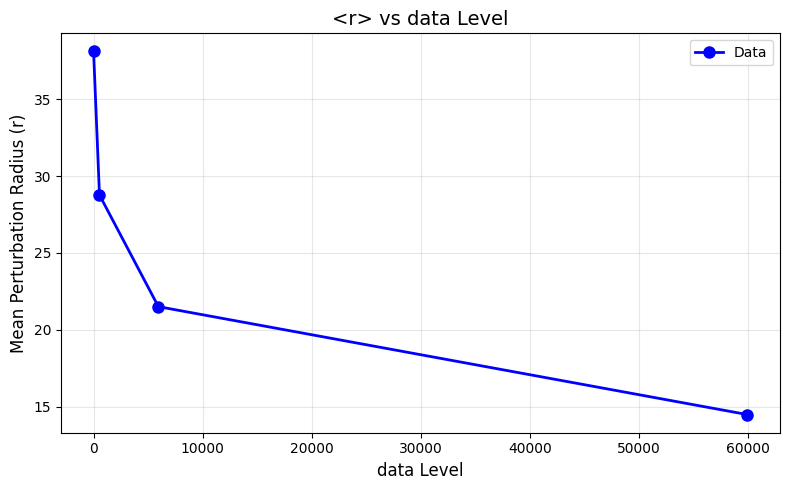

Plot saved to: data_0/log_volume.png


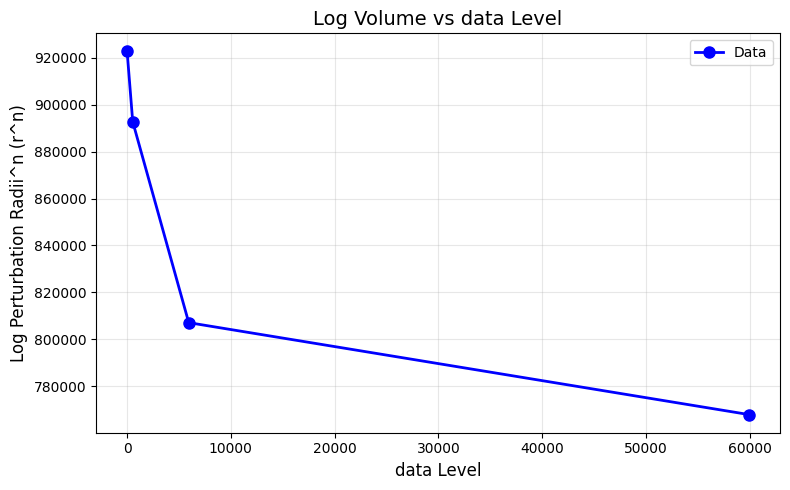

Plot saved to: data_0/radius_histogram.png


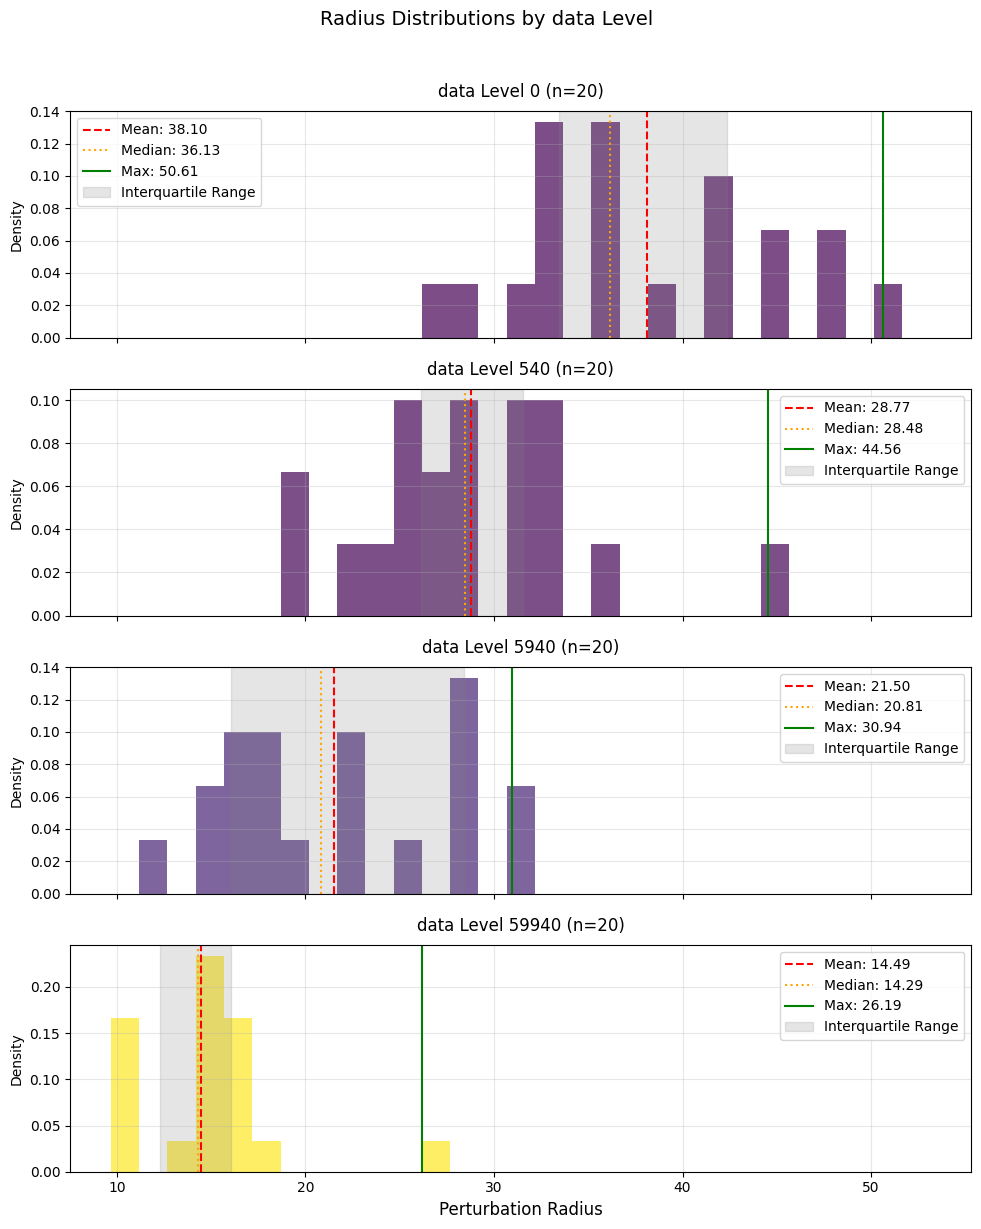

Plot saved to: data_0/log_volume_generalization_acc.png


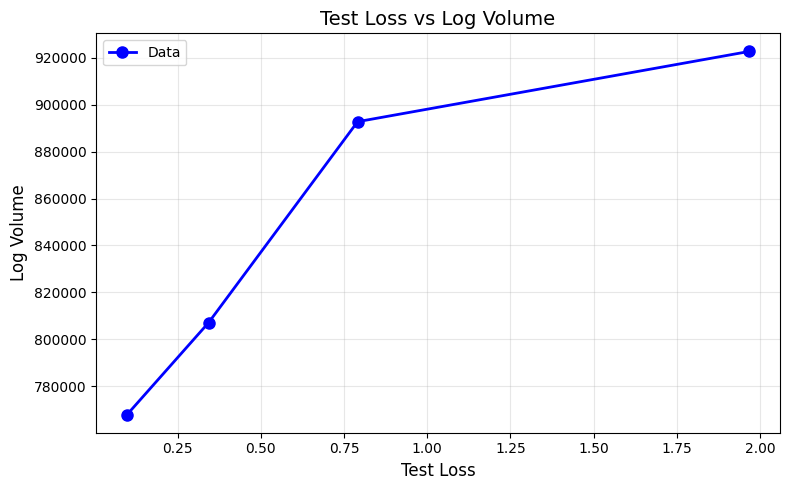

In [6]:
processed_acc = process_wiggle_accuracy_results(data_dictionary, threshold=0.95)
model_data_levels, accuracy_list = extract_data(
    data_dict=processed_acc,
    x_axis_key='model_trained_data',
    y_axis_key='accuracy_r_vals'
)

# Compute different metrics
power_mean_1_acc = compute_power_mean(accuracy_list, exponent=1.0)  # Regular mean
log_exp_r_n_acc = compute_log_power_mean(accuracy_list, exponent=num_params) 

# Average radii
plot_pair_metrics( 
    metric1_values=model_data_levels,
    metric2_values=power_mean_1_acc,
    xlabel=additional_param_level,
    ylabel="Mean Perturbation Radius (r)",
    title="<r> vs "+additional_param_level,
    save_path = directory + "/average_radius.png"
)

# Log volume (r^n)
plot_pair_metrics(
    metric1_values=model_data_levels,
    metric2_values=log_exp_r_n_acc,
    xlabel=additional_param_level,
    ylabel="Log Perturbation Radii^n (r^n)",
    title="Log Volume vs "+additional_param_level,
    #log_scale=True,  # Products often span many orders of magnitude
    save_path = directory + "/log_volume.png"
)

# Radius histogram
plot_metric_distributions(
    categories=model_data_levels,
    metric_values=accuracy_list,
    category_name=additional_param_level,
    metric_name="Perturbation Radius",
    title="Radius Distributions by "+additional_param_level,
    save_path = directory + "/radius_histogram.png"
)

plot_pair_metrics(
    metric1_values=test_loss,
    metric2_values=log_exp_r_n_acc,
    xlabel="Test Loss",
    ylabel="Log Volume",
    title="Test Loss vs Log Volume",
    #log_scale = True,
    save_path = directory + "/log_volume_generalization_acc.png"
)

### Final Results

We measure whether or not these results accurately explain the parameters actually found in training, and if they can accurately explain generalization (test loss).

In [7]:
# Calculate ranks for all arrays
test_loss_ranks = get_ranks(test_loss)
log_exp_r_n_ranks = get_ranks(log_exp_r_n)
log_exp_r_n_acc_ranks = get_ranks(log_exp_r_n_acc)

# Print ranks for verification
print("Ranks for quick verification:")
print(f"test_loss ranks: {test_loss_ranks}")
print(f"log_exp_r_n ranks: {log_exp_r_n_ranks}")
print(f"log_exp_r_n_acc ranks: {log_exp_r_n_acc_ranks}")

indices_match = check_training_explanation(model_data_levels, log_exp_r_n)
violation_count = count_disordered_volumes(test_loss, log_exp_r_n)    
print ("\nLoss:\nDoes it predict the minimas which are actually trained? ", indices_match)
print ("How many violations does it have, when ordering the log volumes? ", violation_count)

indices_match_acc = check_training_explanation(model_data_levels, log_exp_r_n_acc)
violation_count_acc = count_disordered_volumes(test_loss, log_exp_r_n_acc)    
print ("\nAccuracy:\nDoes it predict the minimas which are actually trained? ", indices_match_acc)
print ("How many violations does it have, when ordering the log volumes? ", violation_count_acc)

#print ("model_data_levels", model_data_levels)
#print ("loss_landscape_data_param", loss_landscape_data_param.item())

# Create comprehensive dictionary with ranks
results = {
    "loss_predicts_minimas": bool(indices_match),
    "loss_ordering_violations": int(violation_count),
    "accuracy_predicts_minimas": bool(indices_match_acc),
    "accuracy_ordering_violations": int(violation_count_acc),
    "test_loss_ranks": test_loss_ranks,
    "log_exp_r_n_ranks": log_exp_r_n_ranks,
    "log_exp_r_n_acc_ranks": log_exp_r_n_acc_ranks,
    "test_loss_values": test_loss,
    "log_exp_r_n_values": log_exp_r_n,
    "log_exp_r_n_acc_values": log_exp_r_n_acc,
    "model_data_levels": model_data_levels,
    "loss_landscape_data_param": loss_landscape_data_param.item(),
}

# Save to file
with open(f"{directory}/results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Results saved to results.json")

Ranks for quick verification:
test_loss ranks: [1, 2, 3, 4]
log_exp_r_n ranks: [1, 2, 3, 4]
log_exp_r_n_acc ranks: [1, 2, 3, 4]

Loss:
Does it predict the minimas which are actually trained?  True
How many violations does it have, when ordering the log volumes?  3

Accuracy:
Does it predict the minimas which are actually trained?  True
How many violations does it have, when ordering the log volumes?  3
Results saved to results.json
